<a href="https://colab.research.google.com/github/KaliYuga-ai/KaliYuga-s-Library-of-Historic-AI-Tools/blob/main/CLIP_Guided_Deep_Image_Prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Deep Image Prior
Author: Daniel Russell ([@danielrussruss](https://twitter.com/danielrussruss))

This notebook uses [OpenAI's CLIP](https://github.com/openai/CLIP) model to optimize the weights of the [Deep Image Prior](https://github.com/DmitryUlyanov/deep-image-prior) skip network to output an image that matches a text prompt. 

This is a somewhat minimal implementation intended for research and artistic exploration. Do not use this project or a derivative for commercial work.

This notebook would not be possible without the foundational work established by [Ryan Murdock](https://twitter.com/advadnoun) and [Katherine Crowson](https://twitter.com/rivershavewings).

## Citations and Licenses

```
@misc{radford2021learning,
      title={Learning Transferable Visual Models From Natural Language Supervision}, 
      author={Alec Radford and Jong Wook Kim and Chris Hallacy and Aditya Ramesh and Gabriel Goh and Sandhini Agarwal and Girish Sastry and Amanda Askell and Pamela Mishkin and Jack Clark and Gretchen Krueger and Ilya Sutskever},
      year={2021},
      eprint={2103.00020},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

@article{UlyanovVL17,
    author    = {Ulyanov, Dmitry and Vedaldi, Andrea and Lempitsky, Victor},
    title     = {Deep Image Prior},
    journal   = {arXiv:1711.10925},
    year      = {2017}
}
```

### CLIP
```
MIT License
Copyright (c) 2021 OpenAI

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

### Deep Image Prior
```
Copyright 2018 Dmitry Ulyanov
"Please contact me if you want to use this software in a commercial application." - Dmitry Ulyanov

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Install and import libraries

In [ ]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!pip install kornia einops git+https://github.com/openai/clip madgrad

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (155/155), done.
  Cloning https://github.com/openai/clip to /tmp/pip-req-build-gkgtarxe
  Running command git clone -q https://github.com/openai/clip /tmp/pip-req-build-gkgtarxe
     |████████████████████████████████| 401 kB 5.5 MB/s 
     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369108 sha256=39af157abcf6c383b62dc88ae17c7652f009dda92b04d258071157337fd6e61d
  Stored in directory: /tmp/pip-ephem-wheel-cache-zaxxa5r_/wheels/22/1d/80/448bd5ee71e2ffd7408177d5c1d0b70369eb1b4c806e202574
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=ec891418f395ef5e0008b02ab6d2ad1d1a6fe242e59f462e4f0e2e5e58fc47cd
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb

In [ ]:
import sys
sys.path.append('./deep-image-prior')
from models import *
from utils.sr_utils import *
import clip
import time
import numpy as np
import torch
import torch.optim
from IPython import display
import cv2
from torch.nn import functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import kornia.augmentation as K
from einops import rearrange
from madgrad import MADGRAD
import imageio
import random
import math

device = torch.device('cuda')

In [ ]:
# View GPU details:
!nvidia-smi

Mon Jan 17 04:39:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load CLIP

In [ ]:
clip_model = clip.load('ViT-B/16', device=device)[0]
clip_model = clip_model.eval().requires_grad_(False)
clip_size = 224
clip_normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.augs = T.Compose([
            K.RandomHorizontalFlip(p=0.5),
            K.RandomAffine(degrees=15, translate=0.1, p=0.8, padding_mode='border', resample='bilinear'),
            K.RandomPerspective(0.4, p=0.7, resample='bilinear'),
            K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.7),
            K.RandomGrayscale(p=0.15),
        ])

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        if sideY != sideX:
            input = K.RandomAffine(degrees=0, shear=10, p=0.5)(input)

        max_size = min(sideX, sideY)
        cutouts = []
        for cn in range(self.cutn):
            if cn > self.cutn - self.cutn//4:
                cutout = input
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        cutouts = torch.cat(cutouts)
        cutouts = self.augs(cutouts)
        return cutouts

100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 151MiB/s]


# Optimization loop

In [ ]:
def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def optimize_network(num_iterations, optimizer_type, lr):
    global itt
    itt = 0

    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)

    # Initialize DIP skip network
    input_depth = 3
    net = get_net(
        input_depth, 'skip',
        pad='reflection',
        skip_n33d=128, skip_n33u=128,
        skip_n11=4, num_scales=7,
        upsample_mode='bilinear',
    ).to(device)

    # Initialize input noise
    net_input = torch.zeros([1, input_depth, sideY, sideX], device=device).normal_().div(10).detach()

    # Encode text prompt with CLIP
    target_embed = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()

    if optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr)
    elif optimizer_type == 'MADGRAD':
        optimizer = MADGRAD(net.parameters(), lr, weight_decay=0.01, momentum=0.9)

    try:
        for _ in range(num_iterations):
            optimizer.zero_grad(set_to_none=True)
    
            with torch.cuda.amp.autocast():
              out = net(net_input).float()
            cutouts = make_cutouts(out)
            image_embeds = clip_model.encode_image(clip_normalize(cutouts))
            loss = spherical_dist_loss(image_embeds, target_embed).mean()

            loss.backward()
            optimizer.step()

            itt += 1

            if itt % display_rate == 0 or save_progress_video:
                with torch.inference_mode():
                    image = TF.to_pil_image(out[0].clamp(0, 1))
                    if itt % display_rate == 0:
                        display.clear_output(wait=True)
                        display.display(image)
                        if display_augs:
                            aug_grid = torchvision.utils.make_grid(cutouts, nrow=math.ceil(math.sqrt(cutn)))
                            display.display(TF.to_pil_image(aug_grid.clamp(0, 1)))
                    if save_progress_video and itt > 15:
                        video_writer.append_data(np.asarray(image))

            if anneal_lr:
                optimizer.param_groups[0]['lr'] = max(0.00001, .99 * optimizer.param_groups[0]['lr'])

            print(f'Iteration {itt} of {num_iterations}')
    
    except KeyboardInterrupt:
        pass
    finally:
        return TF.to_pil_image(net(net_input)[0])

# Settings / Generate

In [ ]:
seed = random.randint(0, 2**32)
opt_type = 'MADGRAD' # Adam, MADGRAD
lr = 0.0025 # learning rate
anneal_lr = True # True == lower the learning rate over time

sideX, sideY = 512, 512 # Resolution
num_iterations = 350 # More can be better, but there are diminishing returns
cutn = 16 # Number of crops of image shown to CLIP, this can affect quality

prompt = 'a moody painting of a lonely duckling'

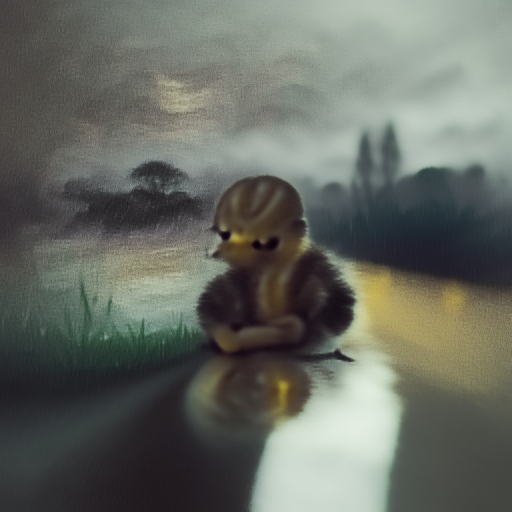

Iteration 350 of 350


In [ ]:
display_rate = 5 # How often the output is displayed.
# If you grab a P100 GPU or better, you'll likely want to set this further apart, like >=20.
# On T4 and K80, the process is slower so you might want to set a faster display_rate (lower number, towards 1-5).

save_progress_video = False
display_augs = False # Display grid of augmented image, for debugging

timestring = time.strftime('%Y%m%d%H%M%S')
if save_progress_video:
    video_writer = imageio.get_writer(f'dip_{timestring}.mp4', mode='I', fps=30, codec='libx264', quality=7, pixelformat='yuv420p')

# Begin optimization / generation
out = optimize_network(num_iterations, opt_type, lr)

# Save final frame and video to a file
out.save(f'dip_{timestring}.png', quality=100)
if save_progress_video:
    video_writer.close()